In [18]:
!python -V

Python 3.10.11


In [2]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

In [3]:
import mlflow 

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("taxi-duration-prediction")

<Experiment: artifact_location='/Users/rashmi/Documents/rashmi/github_repos/AtoZ_ml_ops_course/AtoZ_ml_ops/02-mlflow_exp_tracking/mlruns/1', creation_time=1688650154847, experiment_id='1', last_update_time=1688650154847, lifecycle_stage='active', name='taxi-duration-prediction', tags={}>

In [4]:
df = pd.read_parquet('data/green_tripdata_2022-01.parquet')

In [5]:
df.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,0.50,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,0.50,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,3.25,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,0.50,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,0.50,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75


In [6]:
def read_df(filename):
    df = pd.read_parquet(filename)

    df['duration'] =  df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_df('data/green_tripdata_2022-01.parquet')
df_val = read_df('data/green_tripdata_2022-02.parquet')

In [8]:
len(df_train), len(df_val)

(59603, 66097)

In [9]:
numerical = ['trip_distance']
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)
dv = DictVectorizer() 


train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
print(f'Train Feature matrix size: {X_train.shape}')

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
print(f'Validation Feature matrix size: {X_val.shape}')

Train Feature matrix size: (59603, 471)
Validation Feature matrix size: (66097, 471)


In [12]:
df_train.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,...,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00,1.200000
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,...,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00,8.716667
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,...,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75,16.200000
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,8.250000
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,...,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75,21.033333


In [14]:
#target = 'duration'
y_train = df_train['duration'].values
y_val = df_val['duration'].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

print(f'Train RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Train RMSE: 8.193832544103035


In [16]:
import pickle

In [17]:
with open('models/linear_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [32]:
with mlflow.start_run():
    
    #mlflow.
    mlflow.set_tag("developer", "rashmi")
    mlflow.log_param("train-data-path", "data/green_tripdata_2022-02.parquet")
    mlflow.log_param("test-data-path", "data/green_tripdata_2022-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    ls = Lasso()
    ls.fit(X_train, y_train)
    y_pred = ls.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)


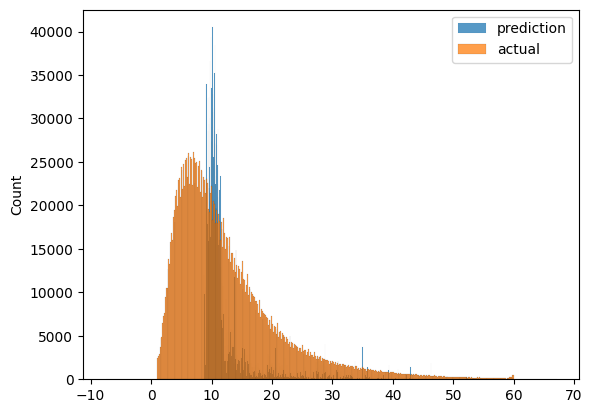

In [20]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()